## Bayesian Model with Proactiv Data

In [1]:
import arviz as az
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

In [2]:
from arviz.utils import Numba
Numba.disable_numba()

In [3]:
data = pd.read_csv('original_dataset_proactiv.csv')

In [4]:
X = data.iloc[:, :9]
y = data['Revenue']

In [5]:
def saturate(x, a):
    return 1 - tt.exp(-a*x)

def carryover(x, strength, length=21):
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags)

In [6]:
with pm.Model() as mmm:
    channel_contributions = []
    
    for channel in X.columns:
        coef = pm.Exponential(f'coef_{channel}', lam=0.0001)
        sat = pm.Exponential(f'sat_{channel}', lam=1)
        car = pm.Beta(f'car_{channel}', alpha=2, beta=2)
        
        channel_data = X[channel].values
        channel_contribution = pm.Deterministic(
            f'contribution_{channel}',
            coef * saturate(
                carryover(
                    channel_data,
                    car
                ),
                sat
            )
        )
        
        channel_contributions.append(channel_contribution)
        
    base = pm.Exponential('base', lam=0.0001)
    noise = pm.Exponential('noise', lam=0.0001)
    
    sales = pm.Normal(
        'sales',
        mu=sum(channel_contributions) + base,
        sigma=noise,
        observed=y
    )
    
    trace = pm.sample(return_inferencedata=True, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, base, car_YouTube_MediaCost, sat_YouTube_MediaCost, coef_YouTube_MediaCost, car_Snapchat_MediaCost, sat_Snapchat_MediaCost, coef_Snapchat_MediaCost, car_Radio_MediaCost, sat_Radio_MediaCost, coef_Radio_MediaCost, car_Pinterest_MediaCost, sat_Pinterest_MediaCost, coef_Pinterest_MediaCost, car_GoogleSearch_MediaCost, sat_GoogleSearch_MediaCost, coef_GoogleSearch_MediaCost, car_Facebook_MediaCost, sat_Facebook_MediaCost, coef_Facebook_MediaCost, car_DV360_MediaCost, sat_DV360_MediaCost, coef_DV360_MediaCost, car_BingSearch_MediaCost, sat_BingSearch_MediaCost, coef_BingSearch_MediaCost, car_Amazon_MediaCost, sat_Amazon_MediaCost, coef_Amazon_MediaCost]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 190 seconds.
There were 220 divergences after tuning. Increase `target_accept` or reparameterize.
There were 476 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6713115610279037, but should be close to 0.8. Try to increase the number of tuning steps.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
There were 246 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'coef_Amazon_MediaCost'}>,
        <AxesSubplot:title={'center':'sat_Amazon_MediaCost'}>,
        <AxesSubplot:title={'center':'car_Amazon_MediaCost'}>,
        <AxesSubplot:title={'center':'coef_BingSearch_MediaCost'}>],
       [<AxesSubplot:title={'center':'sat_BingSearch_MediaCost'}>,
        <AxesSubplot:title={'center':'car_BingSearch_MediaCost'}>,
        <AxesSubplot:title={'center':'coef_DV360_MediaCost'}>,
        <AxesSubplot:title={'center':'sat_DV360_MediaCost'}>],
       [<AxesSubplot:title={'center':'car_DV360_MediaCost'}>,
        <AxesSubplot:title={'center':'coef_Facebook_MediaCost'}>,
        <AxesSubplot:title={'center':'sat_Facebook_MediaCost'}>,
        <AxesSubplot:title={'center':'car_Facebook_MediaCost'}>],
       [<AxesSubplot:title={'center':'coef_GoogleSearch_MediaCost'}>,
        <AxesSubplot:title={'center':'sat_GoogleSearch_MediaCost'}>,
        <AxesSubplot:title={'center':'car_GoogleSearch_MediaCost'}>,
        <AxesS

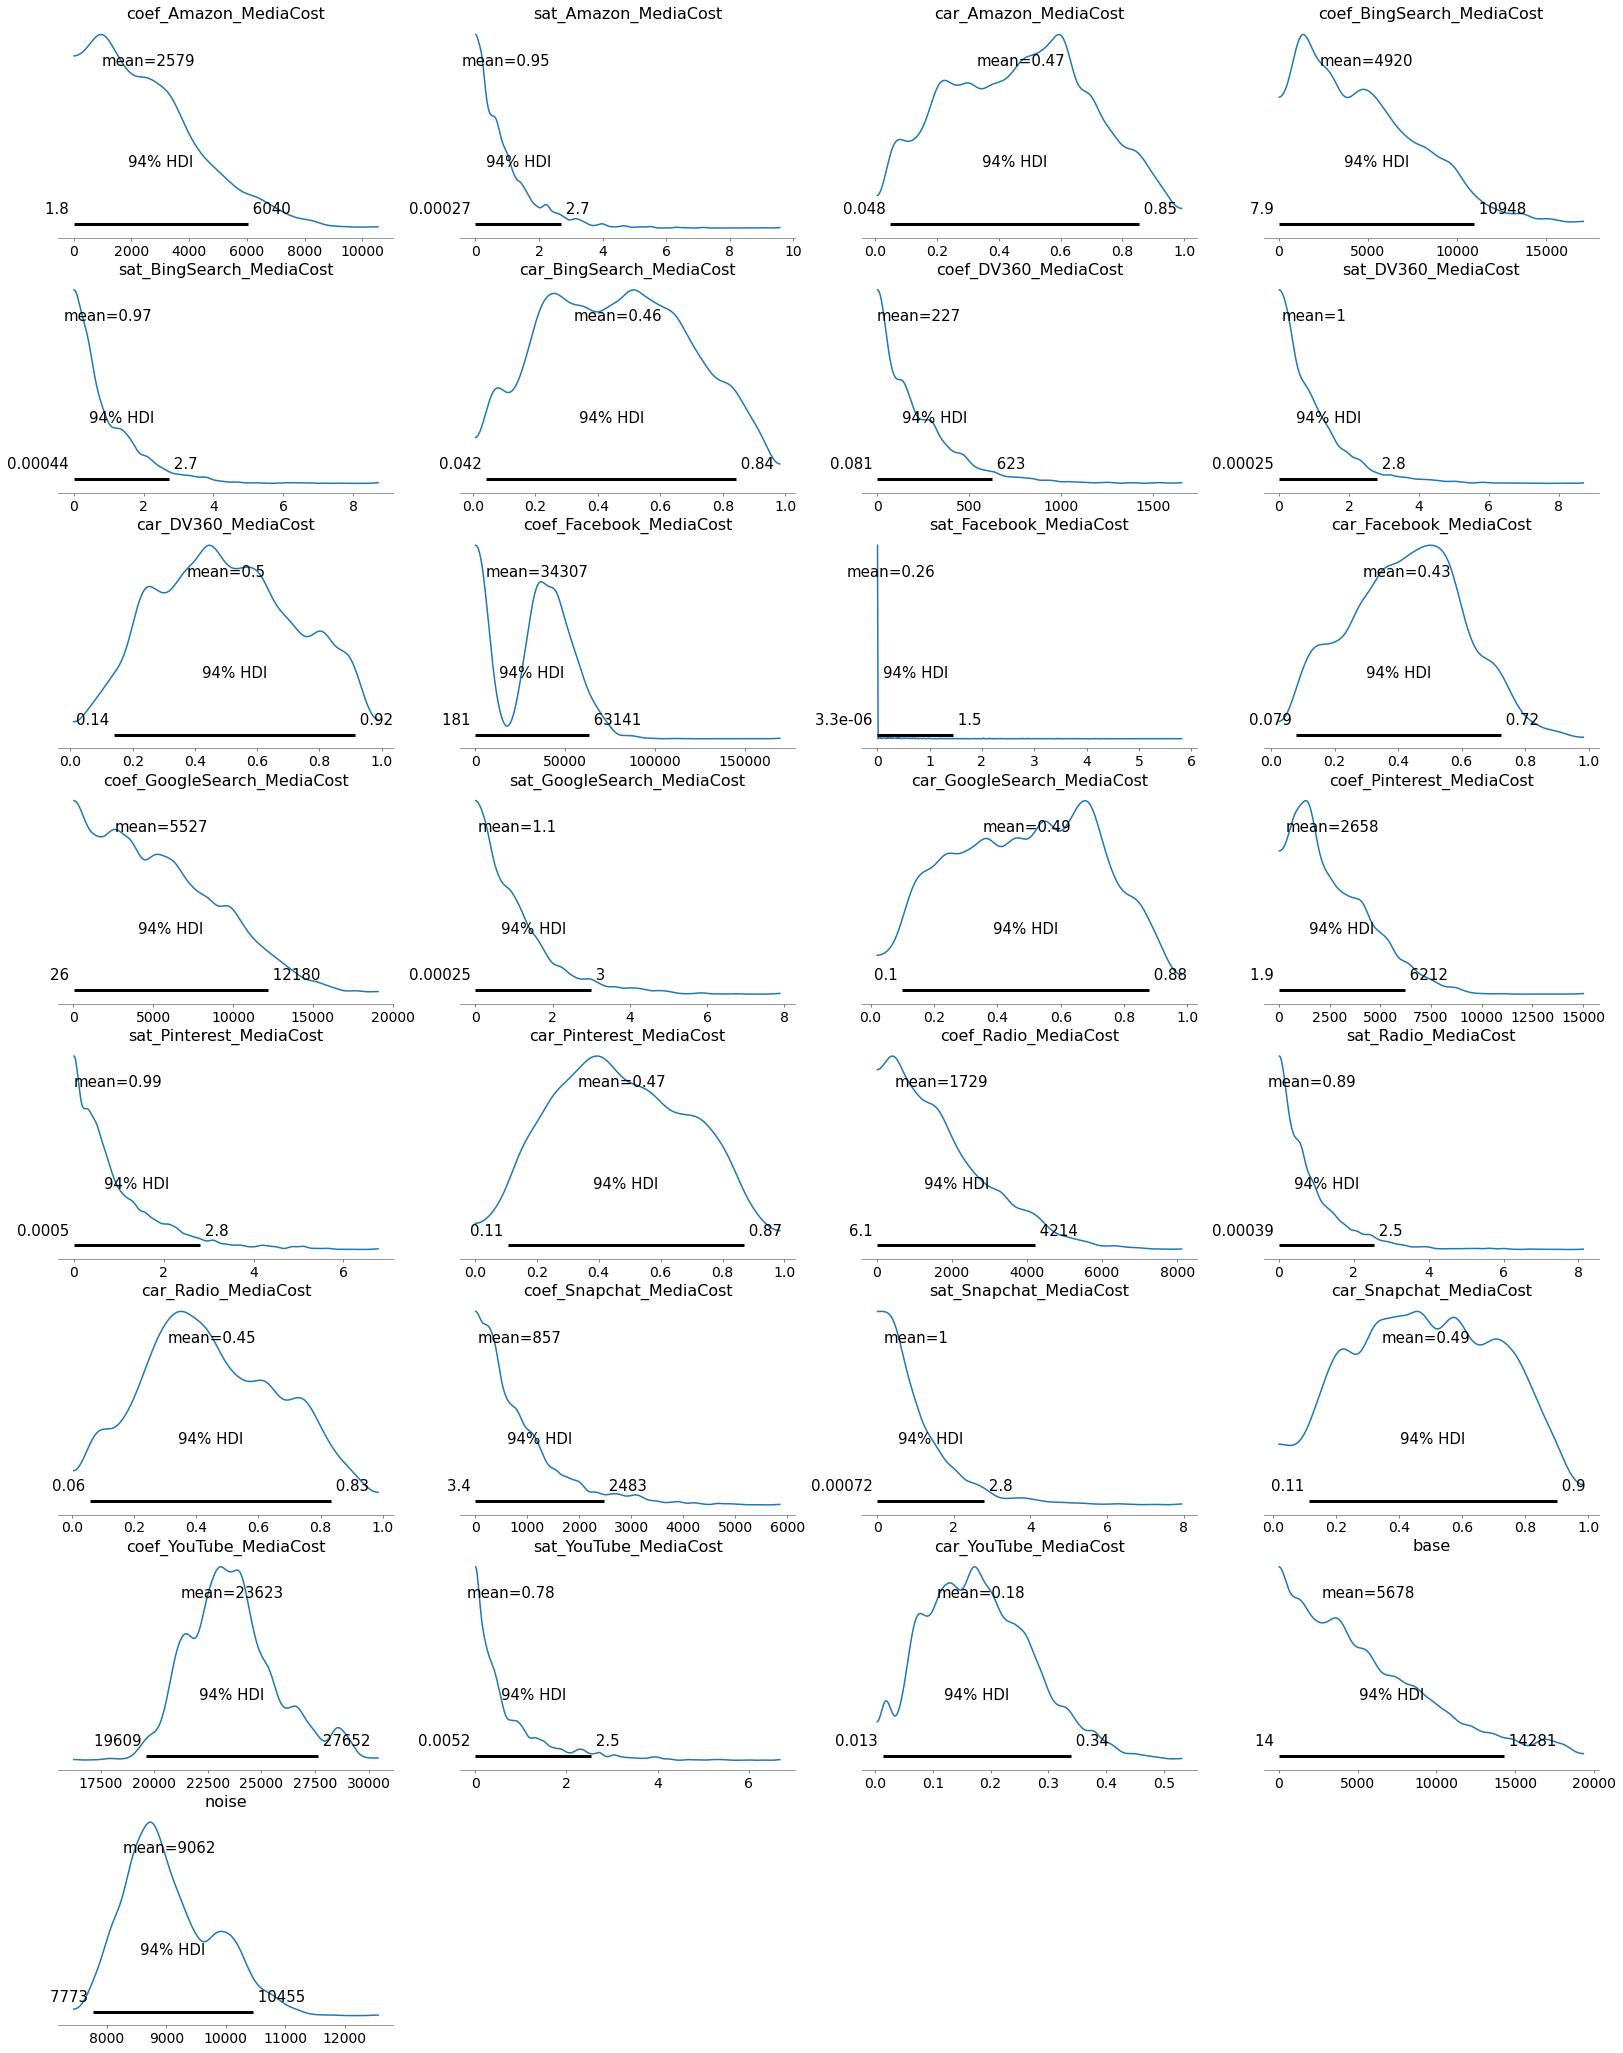

In [7]:
az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

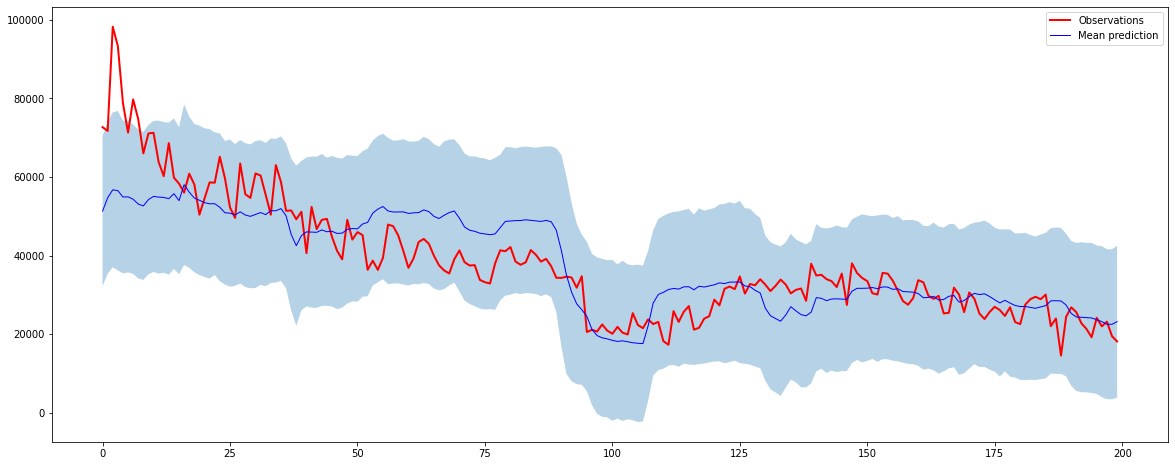

In [8]:
with mmm:
    posterior = pm.sample_posterior_predictive(trace)
means = posterior['sales'].mean(0)
stds = posterior['sales'].std(0)
plt.figure(figsize=(20, 8))
plt.plot(y.values, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()

In [9]:
X.columns

Index(['Amazon_MediaCost', 'BingSearch_MediaCost', 'DV360_MediaCost',
       'Facebook_MediaCost', 'GoogleSearch_MediaCost', 'Pinterest_MediaCost',
       'Radio_MediaCost', 'Snapchat_MediaCost', 'YouTube_MediaCost'],
      dtype='object')

In [10]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'contribution_{channel}']
            .values
            .reshape(4000, 200)
            .mean(0)
           )
channels = X.columns.values
unadj_contributions = pd.DataFrame(
    {'Base': trace.posterior['base'].values.mean()},
    index=X.index
)
for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

In [11]:
adj_contributions.head()

,Base,Amazon_MediaCost,BingSearch_MediaCost,DV360_MediaCost,Facebook_MediaCost,GoogleSearch_MediaCost,Pinterest_MediaCost,Radio_MediaCost,Snapchat_MediaCost,YouTube_MediaCost
0,8074.742642,0.0,6992.147958,0.0,16134.344088,7858.804940,0.0,0.0,0.0,33594.110372
1,7470.599730,0.0,6470.954359,0.0,19394.248460,7272.205152,0.0,0.0,0.0,31081.292299
2,9868.217923,0.0,8548.028419,0.0,29124.621281,9606.311671,0.0,0.0,0.0,41056.590706
3,9339.065186,0.0,8089.716098,0.0,27902.268720,9091.227297,0.0,0.0,0.0,38855.072700
4,8124.171300,0.0,7037.199041,0.0,21910.390896,7908.572173,0.0,0.0,0.0,33800.516590


In [12]:
unadj_contributions.sum(axis=1)

0      51088.058012
1      54486.201170
2      56503.725894
3      56710.104836
4      55059.117708
           ...     
195    23586.654681
196    23031.342579
197    22533.947424
198    22605.712026
199    23126.445217
Length: 200, dtype: float64

In [13]:
unadj_contributions.head()

,Base,Amazon_MediaCost,BingSearch_MediaCost,DV360_MediaCost,Facebook_MediaCost,GoogleSearch_MediaCost,Pinterest_MediaCost,Radio_MediaCost,Snapchat_MediaCost,YouTube_MediaCost
0,5677.89893,0.0,4916.653220,0.0,11345.151058,5526.058494,0.0,0.0,0.0,23622.296311
1,5677.89893,0.0,4918.135914,0.0,14740.260026,5527.112594,0.0,0.0,0.0,23622.793706
2,5677.89893,0.0,4918.298500,0.0,16757.499408,5527.205336,0.0,0.0,0.0,23622.823721
3,5677.89893,0.0,4918.328490,0.0,16963.824382,5527.220200,0.0,0.0,0.0,23622.832833
4,5677.89893,0.0,4918.225309,0.0,15312.944597,5527.218940,0.0,0.0,0.0,23622.829933


In [14]:
import pygal
from IPython.display import SVG, display

In [15]:
def show(chart):
    display(SVG(chart.render(disable_xml_declaration=True)))

In [45]:
def attribution(target="Revenue"):
    def compute_mean(trace, channel):
        return (trace
                .posterior[f'contribution_{channel}']
                .values
                .reshape(4000, 200)
                .mean(0)
               )
    channels = X.columns.values
    unadj_contributions = pd.DataFrame(
        {'Base': trace.posterior['base'].values.mean()},
        index=X.index
    )
    for channel in channels:
        unadj_contributions[channel] = compute_mean(trace, channel)
    adj_contributions = (unadj_contributions
                         .div(unadj_contributions.sum(axis=1), axis=0)
                         .mul(y, axis=0)
                        )
    attribution_table = pd.DataFrame({'Revenue Contributions': adj_contributions.sum(axis=0)[1:], 
                                      'Media Spending': data[channels].sum(axis=0)})
    attribution_table['Attribution'] = attribution_table['Revenue Contributions'] / attribution_table['Media Spending']
    attribution_table.to_excel('Attribution Table.xlsx')
    
    ax = (adj_contributions
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1], labels[::-1],
        title='Channels', loc="center left",
        bbox_to_anchor=(1.01, 0.5)
    )
    
    '''line_chart = pygal.StackedLine(fill=True, explicit_size=True, height=600, width=1000, legend_at_bottom=True, title="Attribution", x_title="Day", y_title=f"{target}")
    for col in adj_contributions.columns:
        line_chart.add(col, adj_contributions[col].values)
    show(line_chart)'''

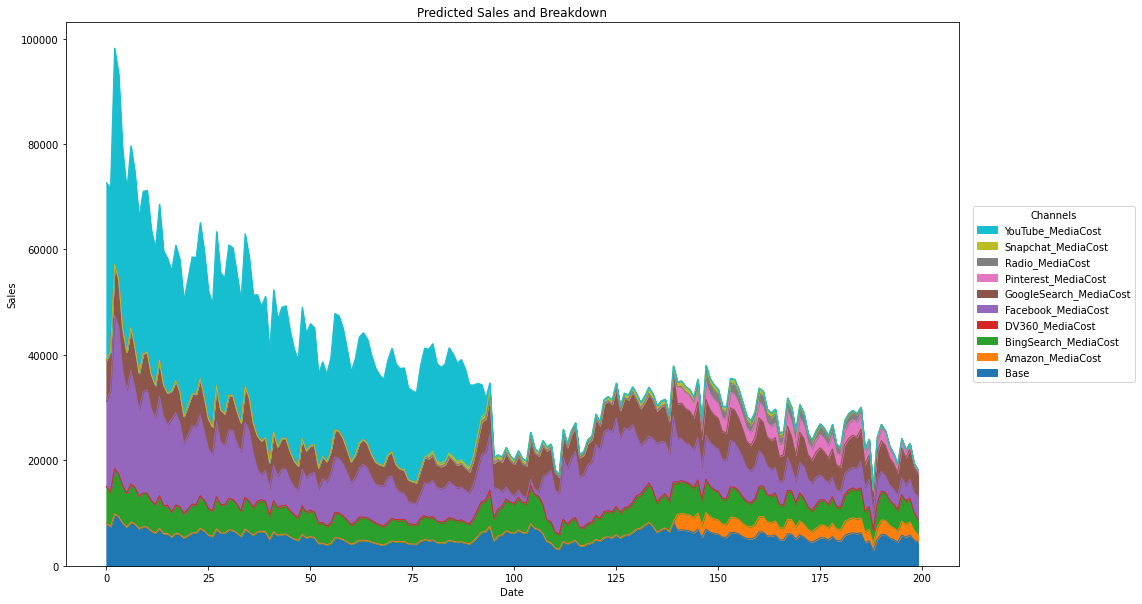

In [46]:
attribution()

In [29]:
if None:
    print(4)